# Morphological Quantification of Bead Sensor Deformation from Muscle Stem Cell Stress
U of Toronto BME1462 Group 8 Final Report

Jacob Delaney, Ziyang Yu, Jorge Angel F. Cruz Ham


----
This is a notebook to deconvolute, segment, extract, quantify, and calculate spehrical harmonics for in vivo polyacrylamide micro beads -based Muscle stem cells regeneration s#tudy. 

In [ ]:
#Imports
import os
import glob
from pathlib import Path
from tqdm import tqdm

import skimage as ski
import tifffile as tif
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# optionally install napari to visualize the data
# !pip install napari
# from napari import Viewer

# Step 1. Image Deconvolution Preprocessing

Using Richardson-Lucy (RL) deconvolution to deblur the confocal microscopy images.

The notebook will try to use GPU-based deconvolution if you have `cupy` and `cucim` installed

In [2]:
#!pip install cup-cuda12x
#!pip install cucim-cu12

# install psf # install psf for Point spread function. You may need to buld wheel and restart the kernel. Windows support not tested

In [3]:
# GPU accelerated Image Enhancement

import psf
from scipy.ndimage import zoom

try:
    import cupy as cp
    import cupyx.scipy.ndimage as cnd
    import cupyx.scipy.signal as csig
except ImportError:
    print("CuPy not installed, using NumPy instead.")
    import numpy as cp
    import scipy.ndimage as cnd
    import scipy.signal as csig

try:
    import cucim.skimage as cski
except ImportError:
    print("Cucim not installed, using skimage instead.")
    import skimage as cski

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/yipgroup/.local/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [4]:
#PSF Constants for Gilbert Lab Confocal
#Optics info:
mag = 40  #magnification
NA = 1.25 #numerical aperature
RI = 1.41 #refractive index
px_cam_um = 12.4*1000 #nm pixel size

#Image generation
n_px_cam = (512, 512) #sensor size

n_z = 250 #number of z slices
z_step = 1 #um zstep
n_points = 50
buffer = 10 #nm buffer from border
ex_wavelength_nm = 635
em_wavelength_nm = 668
pinhole_radius = 85 #um

In [ ]:
#Generate PSF
px_eff_um = px_cam_um/float(mag)
sig = 3
sig_px = sig*1000/px_eff_um

args = dict(
    num_aperture = NA,
    refr_index = RI,
    ex_wavelen=ex_wavelength_nm,
    em_wavelen=em_wavelength_nm,
    shape = (sig_px,sig_px),
    dims = (sig,sig),
    pinhole_radius = pinhole_radius,
)

ker = psf.PSF(psf.ISOTROPIC | psf.CONFOCAL, **args)
print(ker.volume().shape)

kernel = ker.volume()

#flatten PSF for axial resolution
kernel = zoom(ker.volume(), (px_eff_um/z_step/1000, 1,1))

#shrink kernel to optimize calculations
s = int(np.ceil(1000/sig_px))
c = kernel.shape[1]//2

kernel = kernel[:, c-s:c+s+1, c-s:c+s+1,]
print(kernel.shape)

In [ ]:
# functions for GPU Deconvolution

def free_gpu_memory(func):
    def wrapper_func(*args, **kwargs):
        retval = func(*args, **kwargs)
        cp._default_memory_pool.free_all_blocks()
        return retval
    return wrapper_func

@free_gpu_memory
def convolve_psf_cp(gt, kernel, device=0):
    with cp.cuda.Device(device):
        gt_cp = cp.asarray(gt)
        kernel_cp = cp.asarray(kernel)
        im_cp = cnd.convolve(gt_cp, kernel_cp,)
        im = cp.asnumpy(im_cp)
    return im

@free_gpu_memory
def convolve_psf_cp2(gt, kernel, device=0):
    with cp.cuda.Device(device):
        gt_cp = cp.asarray(gt)
        kernel_cp = cp.asarray(kernel)
        im_cp = csig.fftconvolve(gt_cp, kernel_cp,)
        im = cp.asnumpy(im_cp)
    return im

# OOM on 8GB GPU for 512x512x250
# Usees 5GB VRAM with 256x256x250
@free_gpu_memory
def deconvolve_psf_cp_rl(gt, kernel, num_iter=10, device=0):
    with cp.cuda.Device(device):
        gt_cp = cp.asarray(gt)
        kernel_cp = cp.asarray(kernel)
        # deconv_cp = cski.restoration.wiener(gt_cp, kernel_cp, balance=0.1)
        deconv_cp = cski.restoration.richardson_lucy(gt_cp, kernel_cp, num_iter=num_iter)
        deconv = cp.asnumpy(deconv_cp)
    return deconv

@free_gpu_memory
def deconvolve_psf_cp_wn(gt, kernel, balance=0.1, device=0):
    with cp.cuda.Device(device):
        gt_cp = cp.asarray(gt)
        kernel_cp = cp.asarray(kernel)
        deconv_cp = cski.restoration.wiener(gt_cp, kernel_cp, balance=balance)
        # deconv_cp = cski.restoration.richardson_lucy(gt_cp, kernel_cp, num_iter=10)
        deconv = cp.asnumpy(deconv_cp)
    return deconv

In [ ]:
# read your ground truth image from here...
# gt = tif.imread('/path/to/your/image.tif')
im = deconvolve_psf_cp_rl(gt, kernel, num_iter=10, device=0)

# Step 2. Import Image Files for analysis

In [237]:
# Define the directory to search
base_dir = '.'

# Find all .tif and .tiff files in subdirectories

all_tif_files = glob.glob(os.path.join(base_dir, '**', '*.tif'), recursive=True) + \
                glob.glob(os.path.join(base_dir, '**', '*.tiff'), recursive=True)

# Filter files smaller than 1 MB and exclude those in .oif.files subdirectories
# as these are either a single z slice from olympus image utility
# or are not individual-beads ROIs.
filtered_files = [
    file for file in all_tif_files
    if os.path.getsize(file) < 1 * 1024 * 1024 and '.oif.files' not in file
    # if os.path.getsize(file) > 1 * 1024 * 1024 and '.oif.files' not in file # enable this line to read the full image stacks
]

print(filtered_files), len(filtered_files)

['./79584 4dpi/b3.tif', './79584 4dpi/cnt t 2.tif', './10kpa agarose/Image0001_cnt.tif', './10kpa agarose/Image0003_cnt.tif', './10kpa agarose/Image0002_cnt.tif', './79583 4hpi/4hpi 3.tif', './79583 4hpi/4hpi 2 t.tif', './79583 4hpi/cnt 3.tif', './79588 62dpi/Image0011 t.tif', './79588 62dpi/Image0011 t all.tif', './79585 7dpi/cnt 2.tif', './79585 7dpi/cnt 3.tif', './79585 7dpi/cnt 1.tif', './79587 62dpi/Image0003.tif', './79587 62dpi/Image0008 ui cnt.tif', './79588 62dpi_result/Image0011 t_deconv.tif', './79588 62dpi_result/Image0011 t_deconv_wn.tif', './79586 7dpi/7dpi 8.tif', './79586 7dpi/cnt 1.tif', './79586 7dpi/7dpi 7.tif', './79586 7dpi/cnt 2.tif', './79586 7dpi/7dpi 5.tif']


(None, 22)

In [117]:
# this is unused, but could be used to parse the metadata

import toml
import re

def add_quotes_to_values(toml_like_str):
    # This regex assumes keys and values are simple and there are no inline comments
    pattern = r'(\w+\s*=\s*)(\S+)'
    replacement = r'\1"\2"'
    return re.sub(pattern, replacement, toml_like_str)

# convert ij_metadata['Info'] to a dictionary
def parse_ij_metadata(info_string):
    """Parse ImageJ metadata string into a dictionary."""
    metadata = {}
    for line in info_string.split('\n'):
        if '=' in line:
            key, value = line.split('=', 1)
            metadata[key.strip()] = value.strip()
    return metadata

# Parse the metadata
metadata = parse_ij_metadata(imagej_metadata['Info'])

In [114]:
# Convert the ImageJ metadata dictionary to a TOML string
imagej_metadata_toml = toml.dumps(add_quotes_to_values(imagej_metadata['Info']))

# # Parse the TOML string back into a dictionary
# parsed_metadata = toml.loads(imagej_metadata_toml)

# # Display the parsed metadata
# print(parsed_metadata)

In [267]:
imagej_metadata_toml

'ImageJ = "1.54f"\nimages = 22\nslices = 22\nunit = "micron"\nfinterval = 1\nloop = false\nmin = 0.0\nmax = 4095.0\nInfo = " BitsPerPixel = 12\\n DimensionOrder = XYCZT\\n IsInterleaved = false\\n IsRGB = false\\n LittleEndian = true\\n PixelType = uint16\\n Series 0 Name = Series 1\\n SizeC = 1\\n SizeT = 1\\n SizeX = 512\\n SizeY = 512\\n SizeZ = 22\\nAS Level = 9999\\nAbsPositionUnitName = mm\\nAbsPositionValue = 0.0\\nAdjust Outward = 0\\nAdjust Retrun = 0\\nAnalogPMTGain = 4.0\\nAnalogPMTOffset = 24\\nConfocal = ON\\nCountingPMTGain = 0.0\\nCountingPMTOffset = 1.600000\\nCountingPMTVoltage = 0\\nExcitationOutPutLevel = 81.0\\nLightControl = 9999\\nLocation = /Users/gilbertlab/pCloud Drive/Jo/In vivo beads in EDL project/Gilbert-Betz data/nov152023 injury timecourse #2/79584 4dpi/b2.oib\\nMagnification = 40.0\\nNumber = 1\\nObjectiveLens NAValue = 1.25\\nObjectiveLens Name = UPLSAPO40XS  NA:1.25\\nObjectiveLens WDValue = 9999.0\\nObservation Mode = LSM\\nPMTDetectingMode = Analog\\

In [3]:
# we use this funciton instead to read the imagej file as well as the metadata, at least only the ijdescription

def read_ij_hyperstack(fname):
    """
    Read an imagej hyperstack from a TIFF file.
    """
    # import the image stack
    with tif.TiffFile(fname) as t:
        # imagej_hyperstack = t.asarray()
        imagej_metadata = t.imagej_metadata

        # get image resolution from TIFF tags
        tags = t.pages[0].tags
        x_resolution = tags['XResolution'].value
        y_resolution = tags['YResolution'].value
        # resolution_unit = tags['ResolutionUnit'].value
        resolution_yx_um = (y_resolution[0]/y_resolution[1], x_resolution[0]/x_resolution[1])
        try:
            ij_spacing = imagej_metadata['spacing']
        except:
            ij_spacing = 1
        # parse ImageJ metadata from the ImageDescription tag
        # ij_description = tags['ImageDescription'].value
        # ij_description_metadata = tif.tifffile.imagej_description_metadata(ij_description)
        # get ImageJ app metadata
        # ij_metadata = tags['IJMetadata'].value
        # read the whole image stack and get the axes order
        series = t.series[0]
        ij_hyperstack = series.asarray()
        ij_hyperstack_axes = series.axes
    arr = ij_hyperstack.astype(np.uint16)
    return arr, ij_hyperstack_axes, resolution_yx_um, ij_spacing


In [ ]:
# instantiate the napri viewer if you have it installed
viewer = Viewer()

In [110]:
# read the image stack and test the import functions
img, ij_axes, res_yx_um, res_z_um = read_ij_hyperstack(filtered_files[0])

In [130]:
# see our pixel/voxel sizes. This is important since we will use them for morphology quantification 
img_volume_um = np.prod(img.shape[1:]) * np.prod(res_yx_um) * res_z_um * img.shape[0]
resolution_zyx_um = np.array([res_z_um, res_yx_um[0], res_yx_um[1]])

print(
f'Image shape pixels: {img.shape}, axes: {ij_axes},\n\
resolution ZYX (um): {resolution_zyx_um}, \n\
volume (um^3): {img_volume_um}, dtype: {img.dtype}'
)

Image shape pixels: (22, 80, 98), axes: ZYX,
resolution ZYX (um): [1.       3.225806 3.225806], 
volume (um^3): 1794796.583825217, dtype: uint16


In [139]:
resolution_zyx_per_pixel = 1/resolution_zyx_um
resolution_zyx_per_pixel_scaled = resolution_zyx_per_pixel/resolution_zyx_per_pixel.min()
resolution_zyx_per_pixel, resolution_zyx_per_pixel_scaled

(array([1.        , 0.31000004, 0.31000004]),
 array([3.225806, 1.      , 1.      ]))

In [145]:
# from napari import Viewer
# viewer = Viewer()
viewer.add_image(img, name='img',colormap='gray')
# viewer.add_image(img, name='img', colormap='gray')

<Image layer 'img' at 0x76db8d0c8190>

In [75]:
viewer.add_image(labeled_img, name='Image_lbl', colormap='gray')

<Image layer 'Image_lbl' at 0x76db931c7a00>

In [146]:
viewer.add_image(labeled_img, name='image_lbl_filtered', colormap='gray')

<Image layer 'image_lbl_filtered' at 0x76db8dccc490>

### Implementing the Min feret diameter

Due to the lack of native minimum Feret diameter functionality in scikit-image regionprop function, we implemented our own minimum Feret diameter function by inheriting the RegionProperties class in `skimage.measure`. 
Our heuristic comprises a 3D rotating caliper design that goes over four steps: 
- a) **Coordinate Extraction**. We use scikit-image’s `marching_cubes` to extract the surface coordinates from the padded convex image. These coordinates are scaled by the object's spacing. 
- b) **Convex Hull Calculation**. We use `scipy.spatial.ConvexHull` to obtain the convex hull of the 3D coordinates. This gives us both the vertices and the equations of the facets. 
- c) **Facet-wise Projection**. For each facet, the normal vector (from the convex hull equations) is normalized and used to project all vertices. The difference between the maximum and minimum projection values gives the width in that direction. Finally, 
- d) **Minimum Width calculation**. The smallest width found among all facets (which we iteratively minimize from `np.inf`) is returned as the minimum Feret diameter. We report our data using both maximum and minimum Feret diameters.

In [ ]:
import numpy as np
from math import sqrt
from skimage.measure import find_contours, marching_cubes
from scipy.spatial import ConvexHull


def feret_diameter_min_impl(self):
    """
    Compute the minimum Feret diameter of the convex image using the rotating calipers heuristic.
    """

    # Pad the convex image as done in feret_diameter_max
    identity_convex_hull = np.pad(self.image_convex,
                                  2, mode='constant', constant_values=0)
    
    if self._ndim == 2:
        # Get contour coordinates from the convex image
        coordinates = np.vstack(
            find_contours(identity_convex_hull, 0.5, fully_connected='high')
        )
        # Adjust coordinates with the image spacing
        coordinates = coordinates * self._spacing
        
        # Compute the convex hull of the contour points to get ordered vertices
        hull = ConvexHull(coordinates)
        hull_points = coordinates[hull.vertices]
        
        # Use a rotating calipers method to compute the minimum width.
        # For each edge of the convex hull, compute the distance between the two
        # parallel lines orthogonal to that edge that enclose the hull.
        min_width = np.inf
        n = len(hull_points)
        for i in range(n):
            p1 = hull_points[i]
            p2 = hull_points[(i + 1) % n]
            edge = p2 - p1
            edge_length = np.linalg.norm(edge)
            if edge_length == 0:
                continue  # Skip degenerate edges
            # Compute the unit normal (perpendicular) to the edge
            normal = np.array([-edge[1], edge[0]]) / edge_length
            # Project all hull vertices onto the normal direction
            projections = np.dot(hull_points, normal)
            width = projections.max() - projections.min()
            if width < min_width:
                min_width = width
        
        return min_width

    elif self._ndim == 3:
        # Get 3D coordinates using marching cubes
        coordinates, _, _, _ = marching_cubes(identity_convex_hull, level=0.5)
        # Scale coordinates with the image spacing
        coordinates = coordinates * self._spacing

        # Compute the convex hull of the 3D points
        hull = ConvexHull(coordinates)

        # Initialize the minimum width to infinity
        min_width = np.inf

        # Iterate over each facet of the convex hull
        # Each equation in hull.equations is of the form:
        #   a*x + b*y + c*z + d = 0, where [a, b, c] is the facet normal.
        for eq in hull.equations:
            normal = eq[:-1]
            norm = np.linalg.norm(normal)
            if norm == 0:
                continue  # Skip degenerate cases
            normal /= norm

            # Project all convex hull vertices onto the normal direction
            projections = np.dot(hull.points, normal)
            width = projections.max() - projections.min()

            if width < min_width:
                min_width = width

        return min_width

In [165]:
# subclassing skimage.measure.regionprops. we are not using it in this notebook though

class RegionPropertiesDesendant(ski.measure._regionprops.RegionProperties):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._spacing = kwargs.get('spacing', 1)
        self._ndim = len(self._spacing)

    def feret_diameter_min(self):
        return feret_diameter_min_impl(self)

### Two-step region prop
This is done to avoid convex hull creation error, which is required for maximum Feret diameter calculation.
Sources of error:
1. non-simply connected topology from uncleared background tissue and pixel read noise, or;
2. pixel read noise, init points of convex hull were localized outside the image.

- For the first step we compute `'label', 'area', 'bbox', 'centroid', 'extent'` only.
- We filter `area` and `extent`. Regions failing specified morphological criteria—volume smaller than 1000 voxels or overly dense regions with an extent greater than 0.9—were removed. You may customize the parameters.
- We overwrite the filtered mohological area (voxels) on the original binary labels to zero (indicating background),
- We then perform the second regionprops operation to obtain the ferret diameters this time. 

In [174]:
def filter_compute_region_props(labeled_img, 
                                min_volume=200,
                                max_extent=0.9,
                                resolution=np.array([1, 1, 1]),
                                ):
    """
    Filter the labeled image and compute region properties.
    Args:
        labeled_img (ndarray): Labeled image.
    Returns:
        df (DataFrame): DataFrame containing region properties.
    """
    # Do not calculate the feret diameter yet
    props = ski.measure.regionprops_table(
            labeled_img, properties=(
                'label', 'area', 'bbox', 'centroid', 'extent'
                                    #  'feret_diameter_max'
                                    ),
            spacing=resolution_zyx_um,
        )
    df = pd.DataFrame(props)

    # Filter the beads image with the following properties:
    # remove objects with volume < 200 voxels
    # remove dense blobs with extent > 0.9
    df_area_removed = df[df['area'] < min_volume]
    df_extent_removed = df[df['extent'] > max_extent]
    removed_idx = list(set(df_area_removed.index) | set(df_extent_removed.index))
    # print(f'Filtered {len(removed_idx)} objects with volume < 200 voxels or extent > 0.9')

    labeled_img_filtered = labeled_img.copy()
    # remove the selected rows in the binary image
    for index in removed_idx:
        labeled_img_filtered[labeled_img == index+1] = 0

    # need to catch error for failed convex hull creation
    # we deal with this later
    try:
        # recompute the region properties with feret diameter this time
        props_filtered = ski.measure.regionprops_table(
                labeled_img_filtered, properties=('label', 'area', 'bbox',
                                        'centroid', 'extent',
                                        'feret_diameter_max', 'solidity',
                                        ),
            spacing=resolution_zyx_um,
        )

    except Exception as e:
        print(f'Error computing region properties: {e}')
        # If an error occurs, return the original DataFrame
        props_filtered = props

    df_filtered = pd.DataFrame(props_filtered)

    # simple min feret diameter heuristic
    # df_filtered['feret_diameter_min'] = np.sqrt((df_filtered['area']*6) / (np.pi * df_filtered['feret_diameter_max']))

    df_filtered['feret_diameter_min'] = None

    try:
        # compute the aspect ratio
        props_objs = ski.measure.regionprops(labeled_img_filtered,
                        # coordinates='xy',
                        spacing=resolution_zyx_um,
                        cache=True,
                        )
        for props_obj in props_objs:
            # get label
            label = props_obj.label
            feret_min = feret_diameter_min_impl(props_obj)
            #locate the label in the dataframe and add the value
            df_filtered.loc[df_filtered['label'] == label, 'feret_diameter_min'] = feret_min
    except Exception as e:
        print(f'Error computing region properties: {e}')


    return df_filtered, labeled_img_filtered

### Main feature extraction and quantification loop


1. read image, read voxel size
2. perform median filter and gaussian filter
3. apply otsu threasholding
4. perform 2-step region prop 
5. export lable images
6. export masked images
7. write the properties into dataframe

In [268]:
df = pd.DataFrame()

# Iterate through each file in filtered_files
for file in tqdm(filtered_files):

    image_path = Path(file)

    if not os.path.exists('results/'+str(image_path.parent)):
        # Create the directory if it doesn't exist
        os.makedirs('results/'+str(image_path.parent), exist_ok=True)

    # Read the image
    img, ij_axes, res_yx_um, res_z_um = read_ij_hyperstack(file)

    img_volume_um = np.prod(img.shape[1:]) * np.prod(res_yx_um) * res_z_um * img.shape[0]
    resolution_zyx_um = np.array([res_z_um, res_yx_um[0], res_yx_um[1]])

    # print(
    #     f'Image shape pixels: {img.shape}, axes: {ij_axes},\
    #     resolution ZYX (um): {resolution_zyx_um}, \
    #     volume (um^3): {img_volume_um}, dtype: {img.dtype}'
    # )
    # print()

    # Denoise the image
    img_med = ski.filters.median(img, footprint=np.ones((3,3,3)), )
    img_gus = ski.filters.gaussian(img_med, sigma=3, preserve_range=True)

    # Apply Otsu thresholding
    threshold = ski.filters.threshold_otsu(img_gus)
    binary_img = img_gus > threshold

    labeled_img = ski.measure.label(binary_img, connectivity=2)
    # filter and compute region properties
    df_rois, labeled_img_filtered = filter_compute_region_props(
        labeled_img,
        min_volume=1000,
        max_extent=0.9,
        resolution = resolution_zyx_um, # pass the resolution in micron 
    )

    # # Generate CSV file name
    # csv_file_name = os.path.splitext(os.path.basename(file))[0] + '.csv'
    
    # # Save to CSV
    # df.to_csv(csv_file_name, index=False)

    # save the masked label image
    masked_original = img*(labeled_img_filtered>0).astype(np.uint8)
    tif.imwrite(
        'results/'+str(image_path.parent) + '/' + str(image_path.stem) + '_masked.tif',
        masked_original.astype(np.uint16)
    )

    # save the labeled image
    tif.imwrite(
        'results/'+str(image_path.parent) + '/' + str(image_path.stem) + '_label.tif',
        labeled_img_filtered.astype(np.uint16)
    )

    bbox = df

    # Add filename as a column
    # df_rois['filename'] = os.path.splitext(os.path.basename(file))[0]
    df_rois['filename'] = str(image_path)
    df_rois['sample'] = str(image_path.stem)
    df_rois['experiment_group'] = str(image_path.parent)
    df_rois['experiment_group_timepoint_merged'] = str(image_path.parent).split(' ')[1]
    df_rois['exp_or_control'] = 'control' if 'cnt' in str(image_path.stem) else 'experiment'
    
    # Add the df_rois DataFrame to the df DataFrame
    df = pd.concat([df, df_rois], ignore_index=True)



100%|██████████| 22/22 [01:04<00:00,  2.91s/it]


### Cropping images to ROIs for spherical harmonics analysis

In [ ]:
# saving cropped rois in the df for spherical harmonics analysis

for index, row in df.iterrows():
    # Get the coordinates of the bounding box
    image_path = Path(row['filename'])

    if not os.path.exists('results/rois/'+str(image_path.parent)):
        # Create the directory if it doesn't exist
        os.makedirs('results/rois/'+str(image_path.parent), exist_ok=True)

    img_lbl = tif.imread('results/'+str(image_path.parent) + '/' + str(image_path.stem) + '_label.tif')

    # get the bounding box coordinates
    bbox_z0y0x0z1y1x1 = row['bbox-0':'bbox-5'].tolist()
    # crop the image
    labeled_img_filtered_crop = img_lbl[
        bbox_z0y0x0z1y1x1[0]:bbox_z0y0x0z1y1x1[3],
        bbox_z0y0x0z1y1x1[1]:bbox_z0y0x0z1y1x1[4],
        bbox_z0y0x0z1y1x1[2]:bbox_z0y0x0z1y1x1[5],
    ]

    # remove label and set label to 1
    labeled_img_filtered_crop[labeled_img_filtered_crop > 0] = 1

    # Save the cropped image as a TIFF file
    tif.imwrite(
        'results/rois/'+str(image_path.parent) + '/' + str(image_path.stem) + '_cropped_roi_' + str(row['label']) + '.tif',
        labeled_img_filtered_crop.astype(np.uint16)
    )

In [294]:
um_per_pixel_zyx = 1/(resolution_zyx_um * (1/resolution_zyx_um).min())
um_per_pixel_zyx

array([3.225806, 1.      , 1.      ])

In [240]:
# drop nan values in df
df = df.dropna()

In [253]:
# df3.to_csv('bme1462_beads_quant_normalized.csv', index=False)

### Plotting the data with seaborn

Group our data into five groups, and experiment/control for each group

In [272]:
# experiment_groups = sorted(df['experiment_group_timepoint_merged'].unique())
experiment_groups = ['agarose', '4hpi', '4dpi', '7dpi',  '62dpi']
# df.sort_values(by=['experiment_group', 'sample'], inplace=True)
# df.sort_values(by=['experiment_group_timepoint_merged', 'sample'], inplace=True)
experiment_groups

['agarose', '4hpi', '4dpi', '7dpi', '62dpi']

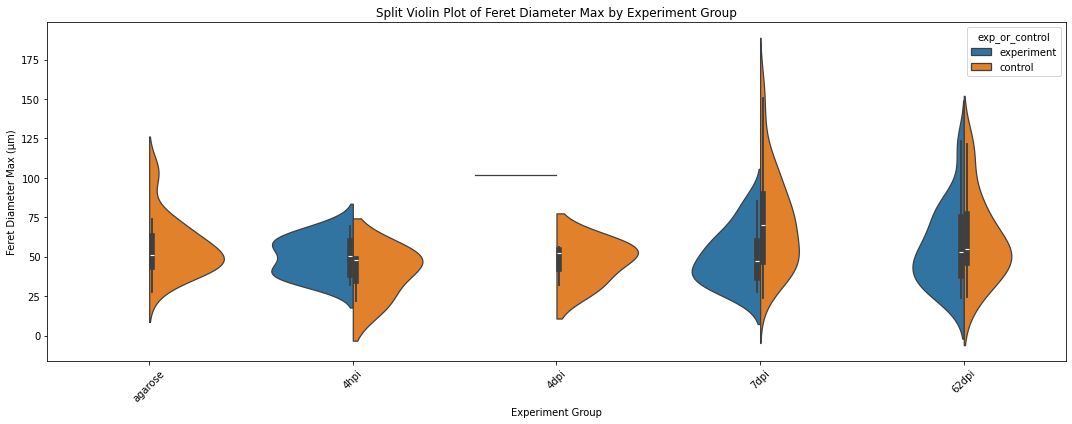

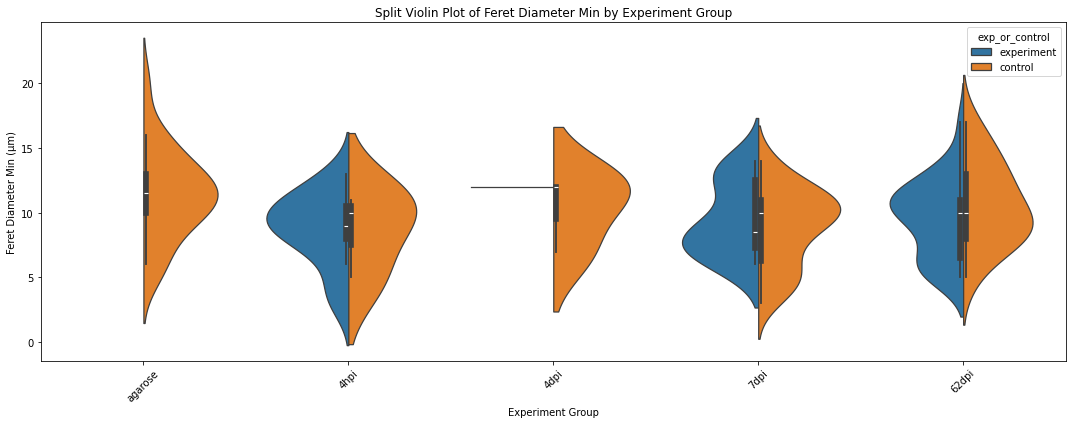

In [273]:
# this is with the raw images only

# Create a split violin plot for feret_diameter_max
plt.figure(figsize=(15, 6))
sns.violinplot(data=df, x='experiment_group_timepoint_merged', y='feret_diameter_max', hue='exp_or_control',
               order=experiment_groups, split=True)
plt.title('Split Violin Plot of Feret Diameter Max by Experiment Group')
plt.xlabel('Experiment Group')
plt.ylabel('Feret Diameter Max (µm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a split violin plot for solidity
plt.figure(figsize=(15, 6))
sns.violinplot(data=df, x='experiment_group_timepoint_merged', y='feret_diameter_min', hue='exp_or_control',
               order=experiment_groups, split=True)
plt.title('Split Violin Plot of Feret Diameter Min by Experiment Group')
plt.xlabel('Experiment Group')
plt.ylabel('Feret Diameter Min (µm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

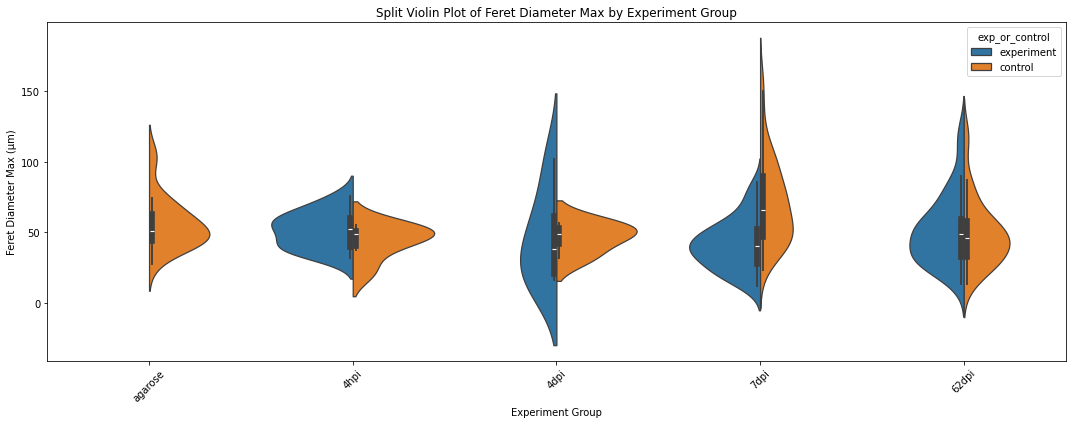

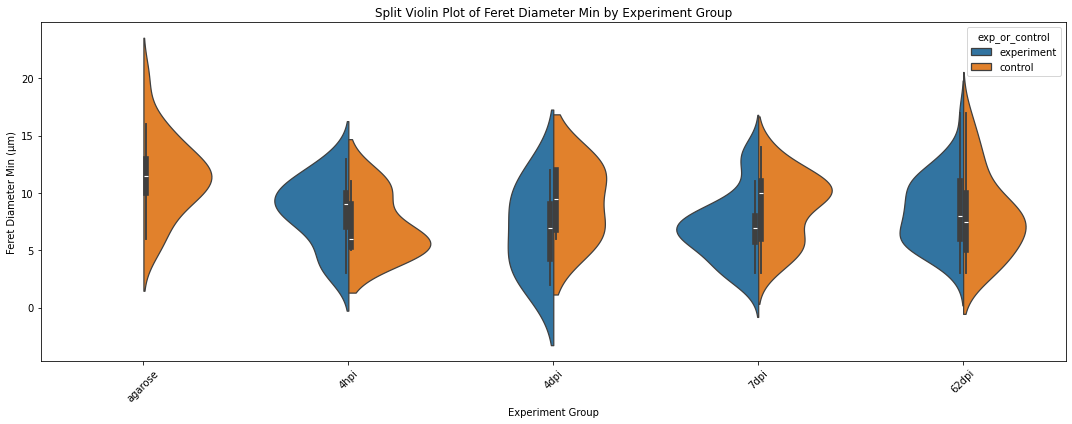

In [274]:
# combiend raw images and ROIs
# df3 = pd.concat([df, df2], ignore_index=True)

# Create a split violin plot for feret_diameter_max
plt.figure(figsize=(15, 6))
sns.violinplot(data=df3, x='experiment_group_timepoint_merged', y='feret_diameter_max', hue='exp_or_control',
               order=experiment_groups, split=True)
plt.title('Split Violin Plot of Feret Diameter Max by Experiment Group')
plt.xlabel('Experiment Group')
plt.ylabel('Feret Diameter Max (µm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a split violin plot for solidity
plt.figure(figsize=(15, 6))
sns.violinplot(data=df3, x='experiment_group_timepoint_merged', y='feret_diameter_min', hue='exp_or_control',
               order=experiment_groups, split=True)
plt.title('Split Violin Plot of Feret Diameter Min by Experiment Group')
plt.xlabel('Experiment Group')
plt.ylabel('Feret Diameter Min (µm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [266]:
# df3.to_csv('bme1462_beads_quant_normalized_all.csv', index=False)

In [210]:
df.head(20)

,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,centroid-0,centroid-1,centroid-2,extent,feret_diameter_max,solidity,feret_diameter_min,filename,sample,experiment_group,experiment_group_timepoint_merged,exp_or_control
0,1,40031.206273,5,60,83,13,89,114,8.269561,238.593089,316.488715,0.534900,104.233779,0.882542,8.0,79584 4dpi/b3.tif,b3,79584 4dpi,4dpi,experiment
1,1,6378.770326,6,361,302,13,373,315,9.096248,1181.786921,992.916769,0.561355,46.186513,0.905465,7.0,79584 4dpi/cnt t 2.tif,cnt t 2,79584 4dpi,4dpi,control
2,2,2247.658060,10,185,73,14,195,83,11.361111,612.290834,249.492199,0.540000,34.757382,0.911392,4.0,79584 4dpi/cnt t 2.tif,cnt t 2,79584 4dpi,4dpi,control
3,3,7356.917815,12,107,280,20,121,293,15.326733,367.586753,922.690020,0.485577,47.064156,0.890428,8.0,79584 4dpi/cnt t 2.tif,cnt t 2,79584 4dpi,4dpi,control
4,1,11456.812609,1,14,180,12,34,198,6.722979,78.863778,611.326861,0.278030,75.609507,0.595457,11.0,79583 4hpi/4hpi 3.tif,4hpi 3,79583 4hpi,4hpi,experiment
5,2,4765.867552,1,34,441,6,49,457,2.971616,131.504419,1447.591007,0.381667,62.665746,0.923387,5.0,79583 4hpi/4hpi 3.tif,4hpi 3,79583 4hpi,4hpi,experiment
6,3,572.320339,2,118,466,5,124,471,2.872727,388.269740,1509.208000,0.611111,20.426281,0.948276,3.0,79583 4hpi/4hpi 3.tif,4hpi 3,79583 4hpi,4hpi,experiment
7,4,2455.774547,2,175,505,8,189,512,4.389831,580.303363,1641.306495,0.401361,47.965479,0.836879,6.0,79583 4hpi/4hpi 3.tif,4hpi 3,79583 4hpi,4hpi,experiment
8,6,1123.829030,2,238,186,5,245,194,2.935185,776.433583,610.394180,0.642857,27.579434,0.947368,3.0,79583 4hpi/4hpi 3.tif,4hpi 3,79583 4hpi,4hpi,experiment
9,8,8064.513871,2,340,300,9,356,315,4.792258,1120.640842,990.988415,0.461310,60.036782,0.846995,7.0,79583 4hpi/4hpi 3.tif,4hpi 3,79583 4hpi,4hpi,experiment


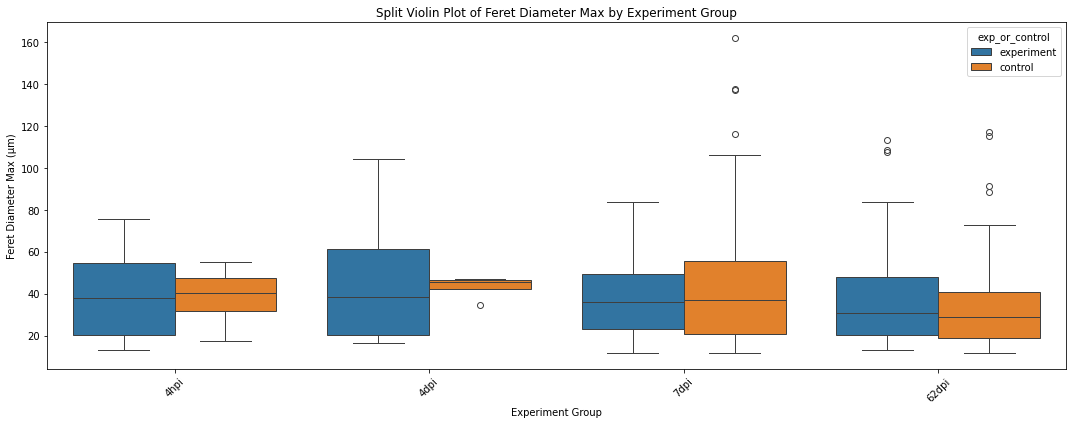

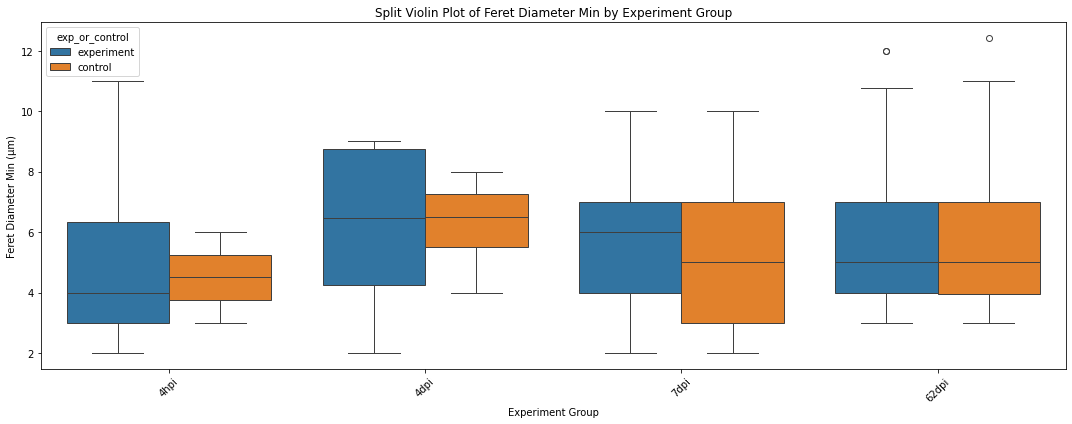

In [203]:

# Create a box plot for feret_diameter_max
plt.figure(figsize=(15, 6))
sns.boxplot(data=df3, x='experiment_group_timepoint_merged', y='feret_diameter_max', hue='exp_or_control',
               order=experiment_groups,)
plt.title('Split Violin Plot of Feret Diameter Max by Experiment Group')
plt.xlabel('Experiment Group')
plt.ylabel('Feret Diameter Max (µm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a split violin plot for solidity
plt.figure(figsize=(15, 6))
sns.boxplot(data=df3, x='experiment_group_timepoint_merged', y='feret_diameter_min', hue='exp_or_control',
               order=experiment_groups, )
plt.title('Split Violin Plot of Feret Diameter Min by Experiment Group')
plt.xlabel('Experiment Group')
plt.ylabel('Feret Diameter Min (µm)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Spherical Harmonics Beads Surface/Beads Morphology Analysis

Implementing a fitting function using least square fitting (np.linalg.lstsq) over the binary labeled beads images to fit spherical harmonics for the beads.
1. Extract beads’ surfaces are first extracted with marching_cubes, 
2. Convert surfaces to spherical coordinates. T
3. he spherical harmonics function (scipy.special.sph_harm) is calculated up to a degree of 5 for each extracted bead, 
4. the real part of the results is used for fitting calculations.

In [220]:
from scipy.special import sph_harm

def cart2sph(x, y, z):
    """
    Convert Cartesian coordinates to spherical coordinates.
    Returns radius r, polar angle theta (0 to pi), and azimuthal angle phi (-pi, pi].
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    # Avoid division by zero by adding a tiny offset in denominator.
    theta = np.arccos(z / (r + 1e-8))
    phi = np.arctan2(y, x)
    return r, theta, phi

def fit_spherical_harmonics(label_image, spacing=(1,1,1), l_max=3):
    """
    Fits spherical harmonics to the surface of a 3D object defined by a label image.
    
    Parameters:
        label_image (ndarray): 3D numpy array containing the labeled object (binary image).
        spacing (tuple): Voxel spacing in (z, y, x) or (x, y, z) order, as used in marching_cubes.
        l_max (int): Maximum degree of spherical harmonics to fit.
        
    Returns:
        coefficients (dict): Dictionary with keys (l, m) and corresponding fitted coefficient.
        center (ndarray): Center of the fitted object (used as the origin for spherical coordinates).
    """
    # Extract surface vertices using marching cubes. Using level=0.5 for binary images.
    verts, faces, normals, values = marching_cubes(label_image, level=0.5)
    # Scale vertices by the spacing.
    verts = verts * np.array(spacing)
    
    # Compute the centroid of the object to center the coordinates.
    center = np.mean(verts, axis=0)
    verts_centered = verts - center

    # Convert centered Cartesian coordinates to spherical (r, theta, phi)
    r_vals, theta, phi = cart2sph(verts_centered[:, 0],
                                  verts_centered[:, 1],
                                  verts_centered[:, 2])
    
    # Build the design matrix for the spherical harmonics.
    # We are modeling the radial distance r as a function of theta and phi.
    harmonics_list = []
    keys = []
    for l in range(l_max + 1):
        for m in range(-l, l + 1):
            # scipy.special.sph_harm returns complex numbers.
            # For a real fit, we take the real part of the spherical harmonic.
            Y_lm = sph_harm(m, l, phi, theta).real
            harmonics_list.append(Y_lm)
            keys.append((l, m))
    # Shape of Y: (number of points, number of coefficients)
    Y = np.vstack(harmonics_list).T

    # Solve the linear system via least squares: r_vals ≈ Y * coeff
    coeffs, residuals, rank, s = np.linalg.lstsq(Y, r_vals, rcond=None)
    
    # Package the coefficients into a dictionary.
    coefficients = {key: val for key, val in zip(keys, coeffs)}
    
    return coefficients, center


In [ ]:
um_per_pixel_zyx

In [334]:
img.shape[::-1]* resolution_zyx_um # flip the image shape zyx to xyz

array([310.      , 993.548248,  29.032254])

### Main loop for running sph_harm

In [376]:
# perform spherical harmonics fitting on the cropped ROIs

df['coeffs'] = None

for idx in range(0,15):
    df['coeffs'+str(idx)] = None

for index, row in df.iterrows():
    # Get the coordinates of the bounding box
    image_path = Path(row['filename'])

    roi_lbl = tif.imread('results/rois/'+str(image_path.parent) + '/' + str(image_path.stem) + '_cropped_roi_' + str(row['label']) + '.tif')

    # convert zyx to xyz
    grid_size_xyz = np.array(roi_lbl.shape)[::-1]
    x, y, z = np.indices(grid_size_xyz)
    center_true = np.array([grid_size_xyz[0]//2, grid_size_xyz[1]//2, grid_size_xyz[2]//2])
    radius_true = np.linalg.norm(center_true)

    # Create a binary sphere if the source is not
    label_image = ((x - center_true[0])**2 +
                    (y - center_true[1])**2 +
                    (z - center_true[2])**2) < radius_true**2

    coefficients, center_estimated = fit_spherical_harmonics(roi_lbl, spacing=(1,1,1), l_max=3)

    # Save the coefficients to a CSV file
    coeffs_df = pd.DataFrame.from_dict(coefficients, orient='index', columns=['coeff'])
    coeffs_df.reset_index(inplace=True)

    for idx, row in coeffs_df.iterrows():
        df.loc[index, 'coeffs'+str(idx)] = row['coeff']
    


### visualize the Data

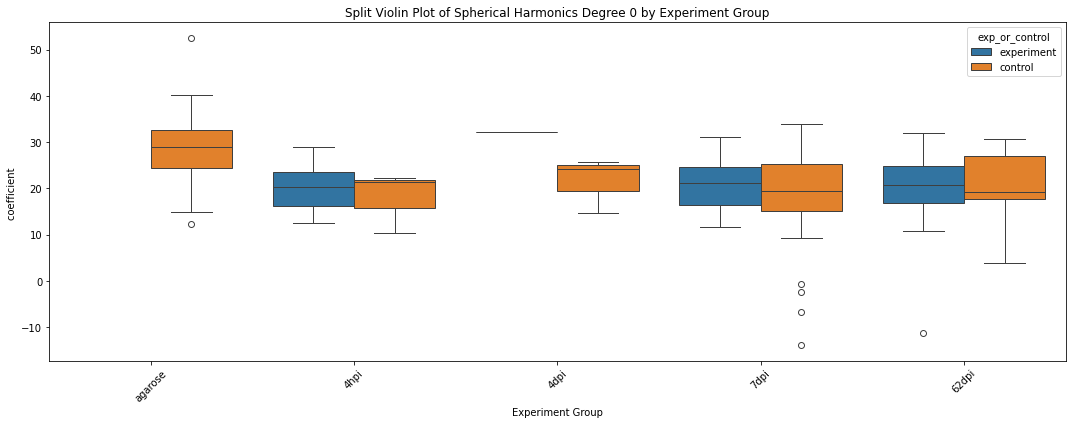

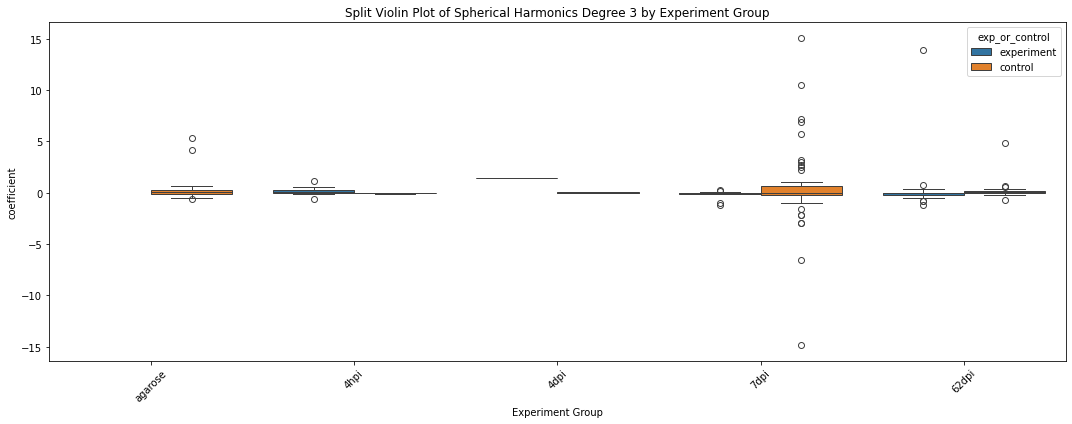

In [384]:

# Create a box plot for feret_diameter_max
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='experiment_group_timepoint_merged', y='coeffs0', hue='exp_or_control',
               order=experiment_groups,)
plt.title('Split Violin Plot of Spherical Harmonics Degree 0 by Experiment Group')
plt.xlabel('Experiment Group')
plt.ylabel('coefficient ')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a split violin plot for solidity
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='experiment_group_timepoint_merged', y='coeffs9', hue='exp_or_control',
               order=experiment_groups, )
plt.title('Split Violin Plot of Spherical Harmonics Degree 3 by Experiment Group')
plt.xlabel('Experiment Group')
plt.ylabel('coefficient')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [377]:
df

,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,centroid-0,centroid-1,...,coeffs6,coeffs7,coeffs8,coeffs9,coeffs10,coeffs11,coeffs12,coeffs13,coeffs14,coeffs15
0,1,60332.969579,3,60,84,15,89,114,8.313211,238.438694,...,8.85148,0.289491,-9.880968,1.417377,0.222063,-1.082314,0.133489,1.082314,0.222063,-1.417377
1,1,14380.849251,4,360,301,16,374,316,9.133140,1181.919446,...,0.929617,0.268674,-0.903698,0.019082,0.013164,-0.039716,-0.071343,0.039716,0.013164,-0.019082
2,2,3298.646319,8,186,73,15,195,82,11.280757,612.292577,...,0.456921,-0.020022,-0.602256,-0.037892,0.03151,0.034614,0.09488,-0.034614,0.03151,0.037892
3,3,17148.798528,10,106,279,22,123,294,15.418083,367.751671,...,0.80526,0.10012,-1.310743,0.07558,-0.019461,0.01628,0.025492,-0.01628,-0.019461,-0.075580
4,1,11663.040262,3,193,279,13,213,298,7.610805,488.979808,...,3.397276,-0.029738,-4.264112,0.030017,0.034993,0.044122,-0.110662,-0.044122,0.034993,-0.030017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,2,26170.648239,0,115,83,12,134,102,4.777336,401.489074,...,1.708155,0.403826,-1.939096,0.223655,0.181913,-0.234911,-0.014448,0.234911,0.181913,-0.223655
160,3,7502.599356,1,66,172,10,78,185,5.137309,229.855455,...,0.936277,0.38911,-0.631863,-0.141845,-0.051526,0.072115,0.040344,-0.072115,-0.051526,0.141845
161,4,7606.657600,1,96,27,11,109,39,5.484268,329.358764,...,0.136212,0.261596,-1.407232,-0.009359,-0.101307,0.110169,-0.137771,-0.110169,-0.101307,0.009359
162,1,5712.797568,0,39,66,9,49,77,4.783242,141.624047,...,0.346295,-0.219335,0.49736,0.22382,0.03529,0.063871,-0.067594,-0.063871,0.03529,-0.223820


In [227]:
"""
examples of Extracted Spherical Harmonic Coefficients:
"""
# Print the extracted spherical harmonic coefficients.
print("Extracted Spherical Harmonic Coefficients:")
for (l, m), coeff in coefficients.items():
    print(f"l = {l}, m = {m}: {coeff:.4f}")

Extracted Spherical Harmonic Coefficients:
l = 0, m = 0: -19200.1177
l = 1, m = -1: 1751802.3810
l = 1, m = 0: 5893.5230
l = 1, m = 1: -1751802.3810
l = 2, m = -2: -11160.3096
l = 2, m = -1: 36.8650
l = 2, m = 0: 9134.0689
l = 2, m = 1: -36.8650
l = 2, m = 2: -11160.3097
l = 3, m = -3: 604432.3060
l = 3, m = -2: 3635.1494
l = 3, m = -1: -468243.6738
l = 3, m = 0: -3940.3362
l = 3, m = 1: 468243.6738
l = 3, m = 2: 3635.1493
l = 3, m = 3: -604432.3060
